Problem: Heavy hitter

Reference:
- Privacy at Scale: Local Differential Privacy in Practice

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Implementation of Random Response Protocol $\pi$ (for user with value $v$) as
\begin{equation}
  \forall_{y\in D} Pr[\pi(v)=y]=
  \begin{cases}
    \frac{e^\epsilon}{e^\epsilon+|D|-1}, & \text{if $y=v$}.\\
    \frac{1}{e^\epsilon+|D|-1}, & \text{if $y\neq v$}.\\
  \end{cases}
\end{equation}

Intuition: We sample the correct answer (response $y$ equals truth value $v$) with higher probability. Therefore, if $\epsilon$ is higher, probability of returning the correct answer is higher which means the privacy is lower. When $\epsilon = 0$, we have the highest privacy protection.

In [3]:
from heavyhitter import heavyhitter as hh
import numpy as np
class ROUser(hh.User):
  def set_epsilon(self, epsilon=0):
    self.eps = epsilon
    pk = [np.exp(self.eps) if np.array_equal(self.val, np.asarray([x])) else 1 
                                                 for x in self.rv.xk]
    pk /= np.exp(self.eps)+len(self.rv.xk)-1
    self.response_rv = stats.rv_discrete(name='response', values=(self.rv.xk, pk))
    
  def response(self, query):
    assert hasattr(self, 'response_rv'), "response requires setting privacy budget epsilon"
    return self.response_rv.rvs(size=1) == query
  
class ROAggregator(hh.Aggregator):
  def aggregate(self, responses):
    return np.mean(responses)

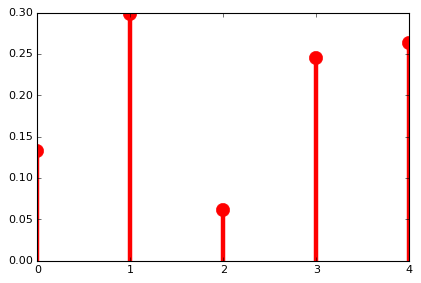

Generating 1000 samples
[(0, 119), (1, 282), (2, 76), (3, 240), (4, 283)]


In [4]:
from scipy import stats
import random

# create the random variable
domain_size = 5
domain = np.arange(domain_size)
prob = np.asarray([random.random() for _ in range(5)])
prob /= sum(prob)
rv = stats.rv_discrete(name='rv', values=(domain, prob))

# plot prob
plt.figure()
fig, ax = plt.subplots(1, 1)
ax.plot(domain, rv.pmf(domain), 'ro', ms=12, mec='r')
ax.vlines(domain, 0, rv.pmf(domain), colors='r', lw=4)
ax.set_xticks(domain)
plt.show()

# sanity check
from collections import Counter
c = Counter([sample for sample in rv.rvs(size=1000)])
print "Generating 1000 samples\n", list(c.items())

Frequency query with local Differential Privacy

In [5]:
users = [ROUser(index=i, rv=rv) for i in range(1000)]
aggregator = ROAggregator(index=0)
aggregator.subscribe(users)

In [6]:
# Frequency query for elements
for eps in [0.0, 10.0]:
  for user in users:
    user.set_epsilon(epsilon=eps)
  print "==== %s users with epsilon=%s ===="%(len(users), users[0].eps)
  for x, p in zip(rv.xk, rv.pk):
    frequency = aggregator.aggregate(aggregator.query(np.asarray([x])))
    print "ele:%s, truth:%0.4f, estimate:%0.4f, diff:%0.4f"%(x,p,frequency, abs(p-frequency))

==== 1000 users with epsilon=0.0 ====
ele:0, truth:0.1330, estimate:0.2040, diff:0.0710
ele:1, truth:0.2979, estimate:0.2100, diff:0.0879
ele:2, truth:0.0614, estimate:0.1980, diff:0.1366
ele:3, truth:0.2448, estimate:0.1960, diff:0.0488
ele:4, truth:0.2630, estimate:0.2050, diff:0.0580
==== 1000 users with epsilon=10.0 ====
ele:0, truth:0.1330, estimate:0.1310, diff:0.0020
ele:1, truth:0.2979, estimate:0.2860, diff:0.0119
ele:2, truth:0.0614, estimate:0.0600, diff:0.0014
ele:3, truth:0.2448, estimate:0.2290, diff:0.0158
ele:4, truth:0.2630, estimate:0.2940, diff:0.0310
